# CNN + GlobalAvgPool
Measure AUPRC and AUROC.
Use median rather than max RCI.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-26 14:25:54.571011
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = True   # break after first fold
MINLEN=1000
MAXLEN=3000   

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE =   'CNRCI_coding_train_counts.K4.gc42.csv'
PICKLE_FILE =   'CNRCI_coding_combined_K4a.pkl'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_list = []
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            rci_list.append(rci_val)
                        cell_line += 1   
                    if len(rci_list) > 0:
                        statistic = np.median(rci_list)
                        gene_to_rci[gene_id] = statistic
                        overall_sum += statistic
        overall_count = len(gene_to_rci.keys())
        overall_mean = overall_sum / overall_count
        print('Number of RCI values lo',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        cache = DATA_DIR+PICKLE_FILE # TO DO: parameterize
        if isfile(cache):
            with open(cache,'rb') as fin:
                alldata = pickle.load(fin)
                labels=alldata[0]
                allids=alldata[1]
                allseq=alldata[2]
                return labels,allids,allseq

        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        with open(cache,'wb') as fout:
            alldata = [labels,allids,allseq]
            pickle.dump(alldata,fout)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [7]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-26 14:26:25.551147
Load RCI values...
Number of RCI values lo 13512
Mean RCI value -0.20493295871695527
Num RCI: 13512
Example RCI: [('ENSG00000000003', 1.50595), ('ENSG00000000419', 1.15523), ('ENSG00000000457', -0.78064)]
Load genes...
2023-01-26 14:26:28.278747
Load sequence...
2023-01-26 14:27:03.199038
Num IDs: 25148
Example IDs: [('ENSG00000187642', 'ENST00000694917.1'), ('ENSG00000186827', 'ENST00000699969.1'), ('ENSG00000160087', 'ENST00000400929.6'), ('ENSG00000127054', 'ENST00000620829.4')]
Count 12220 ones out of 25148 labels.
Num labels: 25148
Example labels: [0, 0, 1, 0]
Num sequences: 25148
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 17

## Model

In [8]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [9]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-01-26 14:27:03.232285
COMPILE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 2990, 64)          2112      
                                                                 
 conv1d_1 (Conv1D)           (None, 2983, 64)          32832     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 36,037
Trainable params: 36,037
Non-trainable params: 0
_________________

## Training

In [16]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )

            print(datetime.now())

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print('Train sizes',X_train.shape,y_train.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))

            print("Compute valiation accuracy")
            print(datetime.now())
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))
            yhat_pred=model.predict(X_valid, verbose=0) 
            
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Score threshold',self.threshold)
            print('Prediction set ones/size',
                  np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            count_ones= len(y_valid[y_valid==1])
            count_zeros= len(y_valid[y_valid==0])
            guess = max(count_ones,count_zeros) / len(y_valid)
            plt.plot(prc_X, prc_Y, marker='.')
            plt.plot([0, 1], [guess,guess], linestyle='--')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()
            # ROC
            auroc = roc_auc_score(y_valid, yhat_pred)*100.
            fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
            plt.plot(fpr, tpr, marker='.')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auc.append(auprc)
            
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            train_genes = None
            X_valid = None
            y_valid = None
            valid_genes = None
            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc

2023-01-26 14:38:15.947897
2023-01-26 14:38:15.948080
splitting
Fold 1
Training example
[147  73  35 ...   0   0   0]
BUILD MODEL
COMPILE
FIT
2023-01-26 14:38:20.038179
Epoch 1/3
627/627 [==============================] - 10s 16ms/step - loss: 0.6604 - accuracy: 0.6028 - val_loss: 0.6514 - val_accuracy: 0.6258
Epoch 2/3
627/627 [==============================] - 9s 15ms/step - loss: 0.6472 - accuracy: 0.6232 - val_loss: 0.6474 - val_accuracy: 0.6248
Epoch 3/3
627/627 [==============================] - 9s 15ms/step - loss: 0.6393 - accuracy: 0.6305 - val_loss: 0.6392 - val_accuracy: 0.6348
2023-01-26 14:38:49.540758


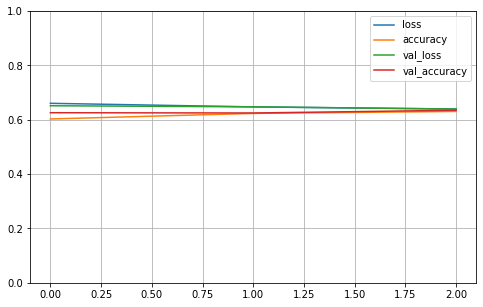

Train sizes (20055, 2997) (20055, 1)
Train set ones/size 9683 / 20055
Compute valiation accuracy
2023-01-26 14:38:49.710561
Valid sizes (5093, 2997) (5093, 1)
Valid set ones/size 2537 / 5093
Range of scores: 0.045852527 to 0.92602915
Score threshold 0.5
Prediction set ones/size 2647 / 5093


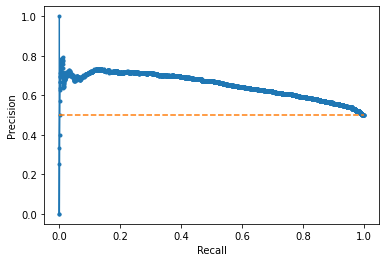

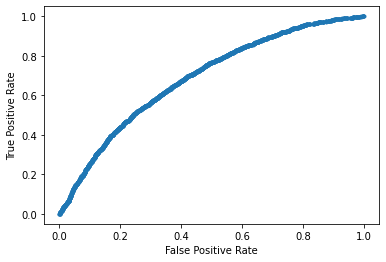

Accuracy: 63.48% Precision: 62.79% Recall: 65.51%
F1: 64.12% AUPRC: 65.22% AUROC: 68.77%
2023-01-26 14:38:51.378668
Break -- this was for code testing only

Cross validation 5 folds 3 epochs
 accuracy mean 63.48% +/- 0.00
 precision mean 62.79% +/- 0.00
 recall mean 65.51% +/- 0.00
 F1 mean 64.12% +/- 0.00
 AUC mean 65.22% +/- 0.00
2023-01-26 14:38:51.380259


In [17]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auc = cvdo.do_cross_validation()   
cvdo = None
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(" AUC mean %.2f%% +/- %.2f" % (np.mean(cv_auc), np.std(cv_auc)))
print(datetime.now())